In [13]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
import scipy as sc
from scipy.optimize import minimize
from scipy.sparse.linalg import eigsh
from scipy.sparse import csr_matrix
from scipy.optimize import newton
from scipy.optimize import root_scalar
import matplotlib.tri as tri
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from scipy.interpolate import interp1d
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from matplotlib.collections import LineCollection
from matplotlib import colors
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from matplotlib.ticker import StrMethodFormatter
from matplotlib.lines import Line2D

In [14]:
e      = 1.6*10**(-19)              #Charge of electron
hbar   = 1.054 * 10**(-34)          #SI  Js 
hbarev = 6.59*10**(-16)             #SI  eVs
me     = 9.1 * 10**(-31)            #SI  kg
meff   = 0.035*me                   #SI  kg
kb     = 1.38 * 10**(-23)           #SI  J/K
kbev   = 8.617 * 10**(-5)           #SI  eV/K
c      = 3*(10**8)                  #SI  m/s

omega  = 0.110                      #SI eV  interlayer hopping energy 
d      = 1.420 *10**(-10)           #SI m  C-C distance in graphene
vf     = 1.5*d*2.866/hbarev         #SI m/s, Fermi velocity for SLG  = 0.905 *10**(6)  #CORRECTED 2.866 for MA=1.05
N      = 1000                       #No. of landau leveles
N_con  = 500                        #No. of landau levels considering (should be less than or equal to N)

In [15]:
upper=Qobj([[0,1],[0,0]])
lower=Qobj([[0,0],[1,0]])

def hk_mono_LS(N_con,B,qx,qy,pos):              #Landau splitting about the dirac point of monolayer with respect to cyclotron frequency ,qx and qy are shifts
    
    lB = np.sqrt(hbar/(e*B))
    anhi     = destroy(N_con)
    
    E_fac = hbarev*vf                              #SI eVm 
    M_fac = lB/np.sqrt(2)                          #SI m 
    
    
    kx=0.5*(anhi+anhi.dag())/M_fac
    ky=0.5j*(anhi-anhi.dag())/M_fac
    
    hk=E_fac*(tensor((kx+qx)+1j*(ky+qy),upper)+tensor((kx+qx)-1j*(ky+qy),lower)).full()
    
    eigenvalue,featurevector=np.linalg.eigh(hk)
    eig_vals_sorted = np.sort(eigenvalue)
    
    if pos:
        eig_vals_sorted = eig_vals_sorted[-N_con:]
        return np.array(eig_vals_sorted)           # Returns Positive Eigenvalues 
    
    return eig_vals_sorted               #eigvals here is in eV

def bi_hk(N_con,B,pos):
      
    lB = np.sqrt(hbar/(e*B))
    anhi     = destroy(N_con)
    E_fac = hbarev*vf                              #SI eVm 
    M_fac = lB/np.sqrt(2)                          #SI m 

    
    kx=0.5*(anhi+anhi.dag())/M_fac
    ky=0.5j*(anhi-anhi.dag())/M_fac
    
    
    bi_hk= -(hbar**2/(2*meff*e))*(tensor((kx+1j*ky)**2,upper)+tensor((kx-1j*ky)**2,lower)).full()
    
    eigenvalue,featurevector=np.linalg.eigh(bi_hk)
    eig_vals_sorted = np.sort(eigenvalue)
    
    if pos:
        eig_vals_sorted = eig_vals_sorted[-N_con:]
        return np.array(eig_vals_sorted)
    
    return eig_vals_sorted               #eigvals here is in eV




ei120  = np.cos(2*np.pi/3) + 1j*np.sin(2*np.pi/3)
ei240  = np.cos(2*np.pi/3) - 1j*np.sin(2*np.pi/3)

# Hopping matrices

Tqb    = omega*np.array([[1,1], [1,1]], dtype=complex)
Tqtr   = omega*np.array([[ei240, 1], [ei120, ei240]], dtype=complex)
Tqtl   = omega*np.array([[ei120, 1], [ei240, ei120]], dtype=complex)
TqbD   = np.array(np.matrix(Tqb).H)
TqtrD  = np.array(np.matrix(Tqtr).H)
TqtlD  = np.array(np.matrix(Tqtl).H)


def  Hk_twist_landau_spec(N,B,theta,N_con):   #8 Band hamiltonain  #gives eigenvalues only about K(or K') point of 1st layer
    
    
    anhi     = destroy(N)
    lB = np.sqrt(hbar/(e*B))
    
    E_fac = hbarev*vf                              #SI eVm 
    M_fac = lB/np.sqrt(2)                          #SI m 
    I_n   = identity(N)
    
    sin_half = np.sin(theta/2)
    cos_half = np.cos(theta/2)
    
    
    ktheta   = 8*np.pi*sin_half/3/np.sqrt(3)/d                   #SI m^-1

    # Hopping vectors in k space
    
    qb      = ktheta*np.array([0, -1])
    qtr     = ktheta*np.array([np.sqrt(3)/2,0.5])
    qtl     = ktheta*np.array([-np.sqrt(3)/2,0.5])
    
    Hk      = np.array(np.zeros((8*N, 8*N)), dtype=complex)
    
    kx      = 0.5*(anhi+anhi.dag())/M_fac
    ky      = 0.5j*(anhi-anhi.dag())/M_fac
    
    
    qx      =  kx
    qy      =  ky
    qx1     =  (kx+qb[0])
    qy1     =  (ky+qb[1])
    qx2     =  (kx+qtr[0])
    qy2     =  (ky+qtr[1])
    qx3     =  (kx+qtl[0])
    qy3     =  (ky+qtl[1])
    
    
    H11     = -E_fac*(tensor((qx+1j*qy),upper)+tensor((qx-1j*qy),lower)).full()  
    H22     = -E_fac*(tensor((qx1+1j*qy1),upper)+tensor((qx1-1j*qy1),lower)).full()
    H33     = -E_fac*(tensor((qx2+1j*qy2),upper)+tensor((qx2-1j*qy2),lower)).full()
    H44     = -E_fac*(tensor((qx3+1j*qy3),upper)+tensor((qx3-1j*qy3),lower)).full()

   
    Hk[0:2*N,0:2*N]       = H11
    Hk[2*N:4*N,2*N:4*N]   = H22
    Hk[4*N:6*N,4*N:6*N]   = H33
    Hk[6*N:8*N,6*N:8*N]   = H44
    Hk[0:2*N,2*N:4*N]     = tensor(I_n,Qobj(Tqb)).full()
    Hk[0:2*N,4*N:6*N]     = tensor(I_n,Qobj(Tqtr)).full()
    Hk[0:2*N,6*N:8*N]     = tensor(I_n,Qobj(Tqtl)).full()
    Hk[2*N:4*N,0:2*N]     = tensor(I_n,Qobj(TqbD)).full()
    Hk[4*N:6*N,0:2*N]     = tensor(I_n,Qobj(TqtrD)).full()
    Hk[6*N:8*N,0:2*N]     = tensor(I_n,Qobj(TqtlD)).full()
    

    Hk = csr_matrix(Hk, dtype=complex)
    
    eigenvalues, eigenvectors = eigsh(Hk, k=2*N_con, sigma=1e-8, tol=1e-12)   #Return just this for all eigenvalues
    final_eigenvalues = np.sort(np.abs(np.round(eigenvalues)))[::2]

    return final_eigenvalues                #eigvals here is in eV



In [16]:
def therm_prob_not_norm(T,E):
    Thermal_probs= np.exp(-E/(kbev*T)) #make sure E is in eV as kbev is in eV/K
    Z_state = np.sum(Thermal_probs)     
    return Thermal_probs/Z_state



def Vn_entropy_therm_prob(L):
    epsilon = 1e-15                   # Add small epsilon to avoid log(0)
    S = -kbev*np.sum(np.where(L > 0, L * np.log(L + epsilon), 0))
    return S


def find_root_newton(Prob_ref, E_test, T_guess, max_iter=5000, tol=1e-5):
    result = newton(func=lambda T: entropy_difference(T, Prob_ref, E_test), x0=T_guess, fprime=None, tol=tol, maxiter=max_iter)
    return result


def find_temperature(Prob_ref, E_test,T_guess, T_bounds=(1e-3, 1000)):
    """Find temperature where S(T) = S_ref using Brent's method"""
    try:
        result = root_scalar(
            lambda T: entropy_difference(T, Prob_ref, E_test),
            bracket=T_bounds,
            method='brentq',
            xtol=1e-6
        )
        return result.root
    except ValueError:
        print(f"Failed to converge for E_test={E_test}, trying fallback...")
        return find_root_newton(Prob_ref, E_test, T_guess)      # Fallback to Newton with good guess

def Heat(E,P1,P2):
    Q=np.sum(E*(P1-P2))
    return Q     #in eV if E is in eV

def Work_sys(P,E1,E2):
    W=np.sum(P*(E1-E2))
    return W     #in eV if E is in eV


def entropy_difference(T_test, Prob_ref, E_test):
    Prob_test = therm_prob_not_norm(T_test,E_test)

    S_ref = Vn_entropy_therm_prob(Prob_ref).real
    S_test = Vn_entropy_therm_prob(Prob_test).real

    return S_ref - S_test 


In [17]:
def QCC(B1, Energy_B1, rc, theta, T_cold, T_hot,Type,saved):
    
    B2 = B1 * rc
    


    Prob_A = therm_prob_not_norm(T_cold, Energy_B1)
    S_A = Vn_entropy_therm_prob(Prob_A)
    Prob_B = Prob_A
    S_B = S_A
    
    try:
        if Type=="Performance":
            
            if saved == True:
            
                if isinstance(theta, (int, float)): 
                    filename = f"spectrum_B_1T_N{N}_theta{np.round(np.degrees(theta),2)}_Ncon{N_con}_rc1000.npz"  #NEW PART
                    data = np.load(filename)
                    B_vals = data["B_vals"]
                    spectra = data["spectra"]
                    idx = np.argmin(np.abs(B_vals - B2))
                    Energy_B2 = spectra[idx]
        
                else: 
                    filename = f"spectrum_B_1T_N{N}_theta{theta}_Ncon{N_con}_rc1000.npz"
                    data = np.load(filename)
                    B_vals = data["B_vals"]
                    spectra = data["spectra"]
                    idx = np.argmin(np.abs(B_vals - B2))
                    Energy_B2 = spectra[idx]
        
                
            else:
            
                if isinstance(theta, (int, float)): 
                    Energy_B2 = Hk_twist_landau_spec(N,B2,theta,N_con)
                    
                elif theta == "Monolayer":
                    Energy_B2 = hk_mono_LS(N_con, B2, 0, 0, True)
                    
                elif theta == "Bilayer":
                    Energy_B2 = bi_hk(N_con, B2, True)


        elif Type=="Twist":
            
            if saved == True:
            
                if isinstance(theta, (int, float)): 
                    data = np.load(f"spectrum_theta_sweep_N{N}_rc{rc}_Ncon{N_con}_steps80.npz")
                    theta_vals_deg = data["theta_vals_deg"]
                    spectra = data["spectra"]
                    idx = np.argmin(np.abs(theta_vals_deg - np.round(np.degrees(theta),2)))
                    closest_theta = theta_vals_deg[idx]
                    Energy_B2 = spectra[idx]
                
                elif theta == "Monolayer":
                    Energy_B2 = hk_mono_LS(N_con, B2, 0, 0, True)
                    
                elif theta == "Bilayer":
                    Energy_B2 = bi_hk(N_con, B2, True)

            else :
                
                if isinstance(theta, (int, float)): 
                    Energy_B2 = Hk_twist_landau_spec(N,B2,theta,N_con)
                    
                elif theta == "Monolayer":
                    Energy_B2 = hk_mono_LS(N_con, B2, 0, 0, True)
                    
                elif theta == "Bilayer":
                    Energy_B2 = bi_hk(N_con, B2, True)
                

        Prob_C = therm_prob_not_norm(T_hot, Energy_B2)
        S_C = Vn_entropy_therm_prob(Prob_C)
        Prob_D = Prob_C
        S_D = S_C

        
        Heat_in = Heat(T_hot, S_C, S_B).real
        Heat_out = Heat(T_cold, S_A, S_D).real
        Work = Heat_in + Heat_out
        eff = Work / Heat_in
        COP_R_CP = np.abs(Heat_out) / np.abs(Work)
        COP_JP = (np.abs(Heat_out) + np.abs(Heat_in)) / np.abs(Work)

        #print(f"{Count},rx = {rc:.3f} ,Qi = {Heat_in:.6f}, Qo = {Heat_out:.6f}, "
        #      f"W = {Work:.6f}, ef = {eff:.4f}, Cp1 = {COP_R_CP:.3f}, Cp2 = {COP_JP:.3f}")

        return Heat_in, Heat_out, Work, eff, COP_R_CP, COP_JP

    except Exception as e:
        print(f"Skipping rc={rc} due to non-convergence: {e}")
        return None, None, None, None, None, None


θ = 1.05: 100%|█████████████████████████████| 480/480 [00:00<00:00, 1041.46it/s]


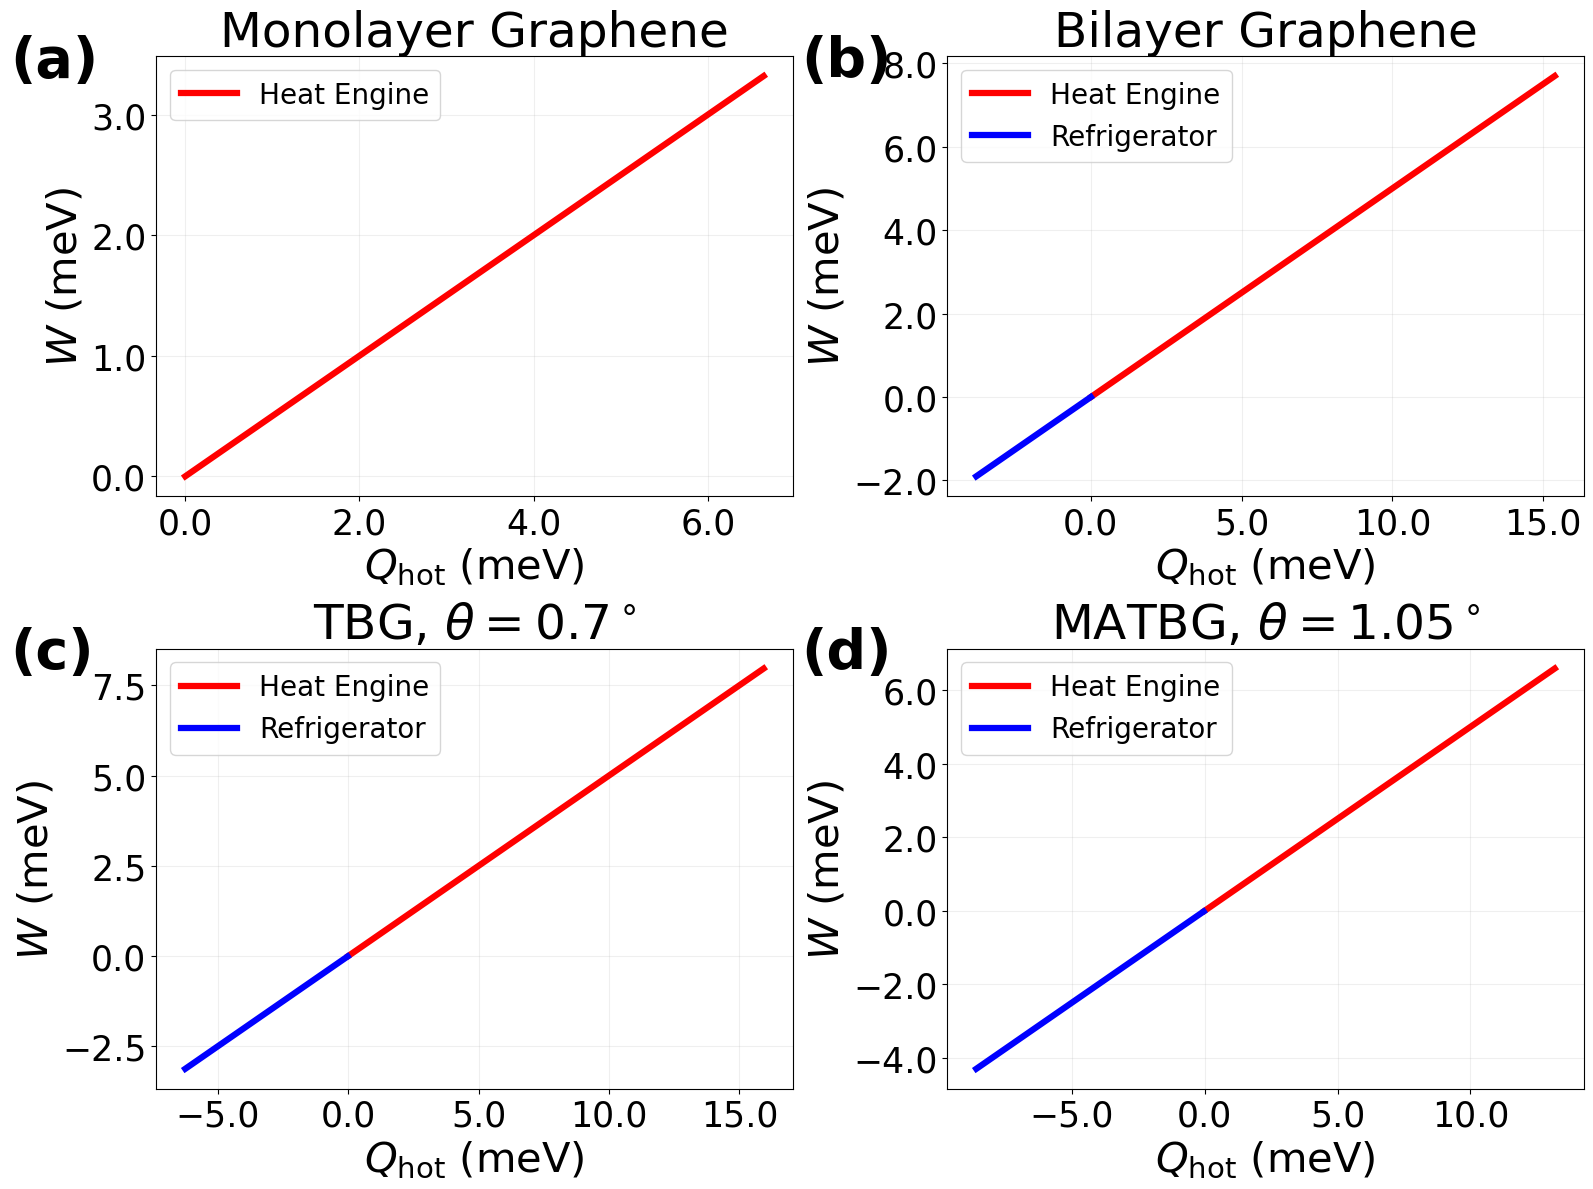

In [18]:
T_cold = 50  # K
T_hot = 100  # K

B1 = 1  # Tesla

Ratio_list = np.linspace(0.3, 4, 480)
Theta_deg = ["Monolayer", "Bilayer", 0.7, 1.05]


fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.grid(True, alpha=0.2)

for idx, theta in enumerate(Theta_deg):
    ax = axs[idx]
    
    if isinstance(theta, (int, float)):
        theta_rad = np.radians(theta)
        filename = f"spectrum_B_1T_N{N}_theta{np.round(theta, 2)}_Ncon{N_con}_rc1000.npz"
    else:
        theta_rad = theta
        filename = f"spectrum_B_1T_N{N}_theta{theta}_Ncon{N_con}_rc1000.npz"

    data = np.load(filename)
    B_vals = data["B_vals"]
    spectra = data["spectra"]
    iB = np.argmin(np.abs(B_vals - B1))
    Energy_B1 = spectra[iB]

    Q_in_pos, W_pos = [], []
    Q_in_neg, W_neg = [], []

    for rc in tqdm(Ratio_list, desc=f"θ = {theta}"):
        Heat_in, Heat_out, work, eff, *_ = QCC(B1, Energy_B1, rc, theta_rad, T_cold, T_hot,Type="Performance", saved=True)
        if work is not None and Heat_in is not None:
            qin = Heat_in * 1000
            
            w = work * 1000
            if w > 0:
                Q_in_pos.append(qin)
                W_pos.append(w)
            elif w < 0:
                Q_in_neg.append(qin)
                W_neg.append(w)


    if Q_in_pos:
        ax.plot(Q_in_pos, W_pos, color='red', label='Heat Engine', linewidth=4.5)
    if Q_in_neg:
        ax.plot(Q_in_neg, W_neg, color='blue', label='Refrigerator', linewidth=4.5)

    if isinstance(theta, (float, int)):
        if np.isclose(theta, 0.7):
            theta_label = r"TBG, $\theta = 0.7^\circ$"
        elif np.isclose(theta, 1.05):
            theta_label = r"MATBG, $\theta = 1.05^\circ$"
        else:
            theta_label = rf"$\theta = {theta:.2f}^\circ$"
    else:
        theta_label = theta + " Graphene"

    ax.set_title(theta_label, fontsize=35)
    ax.set_xlabel(r"$Q_{\mathrm{hot}}$ (meV)", fontsize=30)
    ax.set_ylabel(r"$W$ (meV)", fontsize=30)
    ax.legend(fontsize=20, loc='upper left')
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
subplot_labels = ['(a)', '(b)', '(c)', '(d)']

for idx, theta in enumerate(Theta_deg):
    ax = axs[idx]
    ax.text(-0.23, 1.05, subplot_labels[idx], transform=ax.transAxes,
            fontsize=40, va='top', ha='left',fontweight='bold',)

plt.tight_layout()
plt.show()


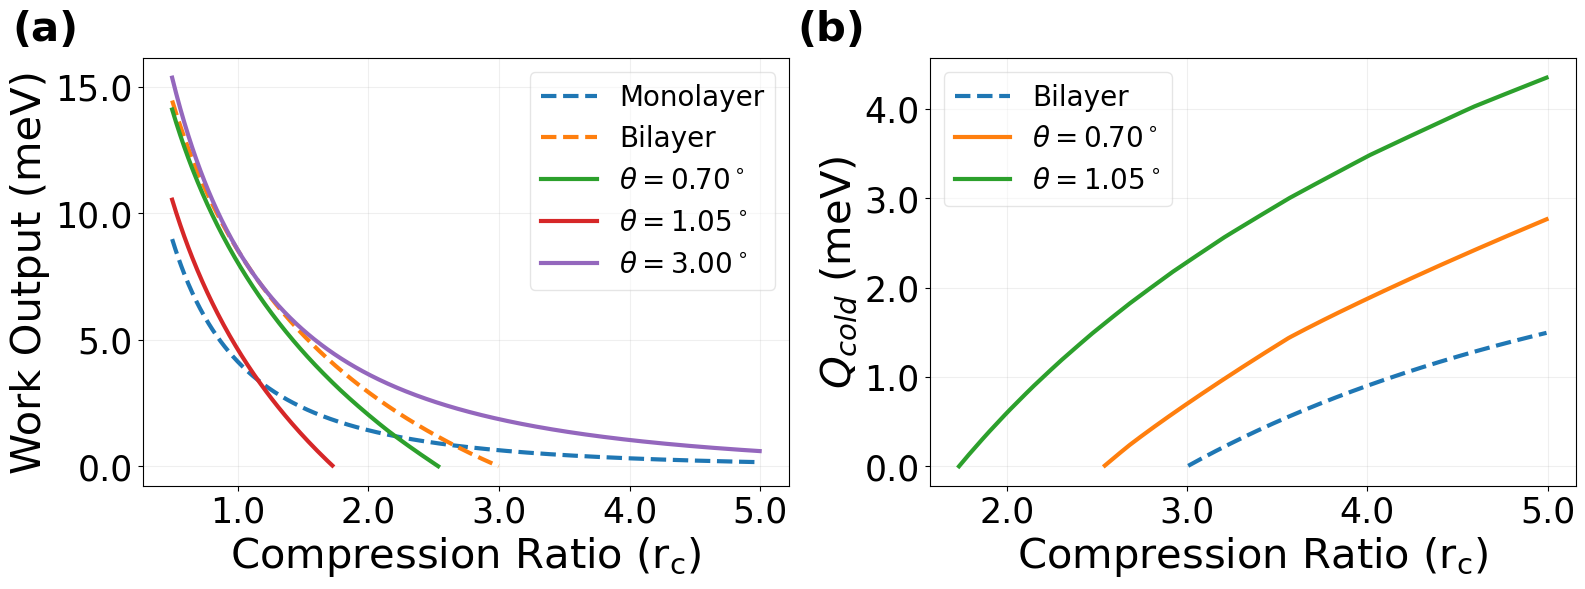

In [19]:
T_cold = 50  # Cold reservoir temperature (K)
T_hot = 150  # Hot reservoir temperature (K)

c_eff = 1 - T_cold / T_hot  # Carnot efficiency

B1 = 1  # Magnetic field in Tesla

Theta_deg = ["Monolayer", "Bilayer", 0.7, 1.05, 3]
Theta = [np.radians(t) if isinstance(t, (int, float)) else t for t in Theta_deg]


Ratio = np.linspace(0.5, 8, 974)


all_efficiencies_HE = {}
all_work_HE = {}
all_rc_HE={}

all_COP_RE = {}
all_Qc_RE = {}
all_rc_RE={}


for theta in Theta:
     
    if isinstance(theta, (int, float)):  # If theta is a numerical value
        filename = f"spectrum_B_1T_N{N}_theta{np.round(np.degrees(theta),2)}_Ncon{N_con}_rc1000.npz"  #NEW PART
        data = np.load(filename)
        B_vals = data["B_vals"]
        spectra = data["spectra"]    
        idx = np.argmin(np.abs(B_vals - B1))
        Energy_B1 = spectra[idx]
    
    elif theta == "Monolayer":
        Energy_B1=hk_mono_LS(N_con, B1, 0, 0,True)
    
    elif theta == "Bilayer":
        Energy_B1=bi_hk(N_con, B1,True)

    perf_HE, output_HE,rc_HE = [], [] ,[]
    perf_RE, output_RE,rc_RE = [], [] ,[]
    
    all_T_4 , all_T_2=[] ,[]
    all_T_2.append(T_cold)
    all_T_4.append(T_hot)
    
    Count=0
    for rc in Ratio:
        Count+=1
        Heat_in, Heat_out, work, eff, COP_R_CP, COP_JP = QCC(B1, Energy_B1, rc, theta, T_cold, T_hot,Type="Performance",saved=True)

        if work > 0 and Heat_in > 0 and Heat_out < 0 and rc < 5:
            perf_HE.append(eff)
            output_HE.append(work*1000)
            rc_HE.append(rc)

        elif work < 0 and Heat_in < 0 and Heat_out > 0 and rc < 5:
            perf_RE.append(COP_R_CP)
            output_RE.append(Heat_out*1000)
            rc_RE.append(rc)

    all_efficiencies_HE[theta] = perf_HE
    all_work_HE[theta] = output_HE
    all_rc_HE[theta] = rc_HE

    all_COP_RE[theta] = perf_RE
    all_Qc_RE[theta] = output_RE
    all_rc_RE[theta] = rc_RE


def plot_data(ax, x_data, y_data, theta_labels, ylabel, legend_loc='best', subplot_label=None, show_xname=False):  # New: `show_xname`

    if subplot_label:
        ax.annotate(f'({subplot_label})', xy=(-0.10, 1.02), xycoords='axes fraction',
                    fontsize=30, weight='bold', ha='right', va='bottom')

    for theta, x, y in zip(Theta, x_data, y_data):
        if isinstance(theta, (int, float)):
            theta_label = f"$\\theta = {np.degrees(theta):.2f}^\\circ$"
            linestyle = "-"
        else:
            theta_label = theta
            linestyle = "--" if theta in ["Monolayer", "Bilayer"] else "-"
        
        if len(x) > 0 and len(y) > 0:
            ax.plot(x, y, label=theta_label, linestyle=linestyle, linewidth=3)
    
    ax.set_ylabel(ylabel, fontsize=30)
    
    if show_xname:
        ax.set_xlabel(r"Compression Ratio ($\text{r}_\text{c}$)", fontsize=30)  
    else:
        ax.set_xlabel("")  # Hide otherwise
    
    ax.legend(fontsize=20, loc=legend_loc, framealpha=0.5)

fig1, axs1 = plt.subplots(1, 2, figsize=(16, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Common settings
for ax in axs1.flat:
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.grid(True, alpha=0.2)
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))

# Heat Engine - General
plot_data(axs1[0], 
          [all_rc_HE[theta] for theta in Theta], 
          [all_work_HE[theta] for theta in Theta],
          Theta,
          r"Work Output (meV)",
          subplot_label='a',
          show_xname=True)

plot_data(axs1[1], 
          [all_rc_RE[theta] for theta in Theta], 
          [all_Qc_RE[theta] for theta in Theta],
          Theta,
          r"$Q_{cold}$ (meV)", 
          subplot_label='b',
          show_xname=True)

plt.tight_layout()
plt.show()

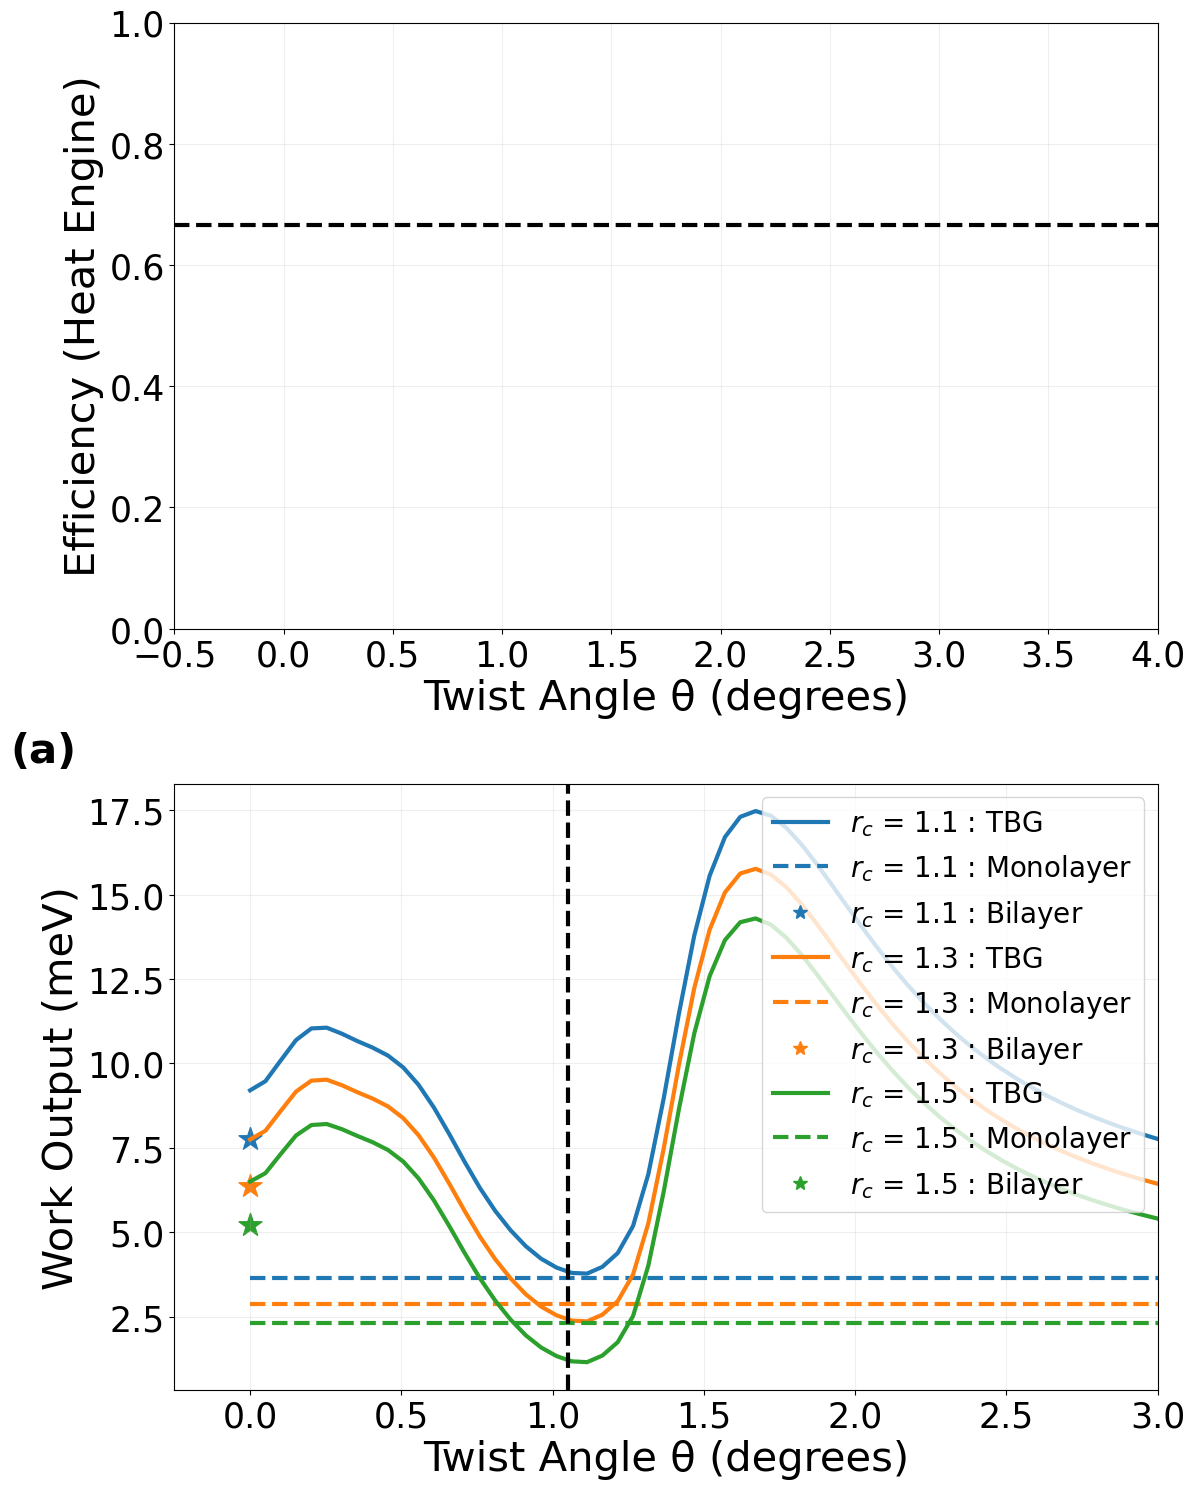

In [20]:
T_cold = 50  # Cold reservoir temperature (K)
T_hot = 150  # Hot reservoir temperature (K)
B1 = 1  # Magnetic field in Tesla


carnot_eff = 1 - T_cold/T_hot


Theta_deg = ["Monolayer", "Bilayer"] + np.linspace(0.0001, 4, 80).tolist()
Theta = [np.radians(t) if isinstance(t, (int, float)) else t for t in Theta_deg]


rc_values = [1.1, 1.3, 1.5]


efficiencies_dict = {rc: [] for rc in rc_values}
work_dict = {rc: [] for rc in rc_values}


monolayer_eff = {rc: None for rc in rc_values}
bilayer_eff = {rc: None for rc in rc_values}
monolayer_work = {rc: None for rc in rc_values}
bilayer_work = {rc: None for rc in rc_values}


valid_theta_deg = []
Count=0
for theta in Theta:
    Count+=1

    if isinstance(theta, (int, float)):
        data = np.load(f"spectrum_theta_sweep_N{N}_rc{B1}_Ncon{N_con}_steps80.npz")
        idx = np.argmin(np.abs(data["theta_vals_deg"] - np.round(np.degrees(theta), 2)))
        Energy_B1 = data["spectra"][idx]
    elif theta == "Monolayer":
        Energy_B1 = hk_mono_LS(N_con, B1, 0, 0, True)
    elif theta == "Bilayer":
        Energy_B1 = bi_hk(N_con, B1, True)
    

    valid = True
    temp_eff = {rc: None for rc in rc_values}
    temp_work = {rc: None for rc in rc_values}
    
    for rc in rc_values:
        Heat_in, Heat_out, work, eff, _, _ = QCC(B1, Energy_B1, rc, theta, T_cold, T_hot,Type="Twist",saved=True)
        if eff is None or work is None:
            valid = False
            break
        temp_eff[rc] = eff
        temp_work[rc] = work *1000
    
    if not valid and isinstance(theta, (int, float)):
        continue
    
    if isinstance(theta, (int, float)):
        valid_theta_deg.append(np.degrees(theta))
    
    for rc in rc_values:
        if theta == "Monolayer":
            monolayer_eff[rc] = temp_eff[rc]
            monolayer_work[rc] = temp_work[rc]
        elif theta == "Bilayer":
            bilayer_eff[rc] = temp_eff[rc]
            bilayer_work[rc] = temp_work[rc]
        else:
            efficiencies_dict[rc].append(temp_eff[rc])
            work_dict[rc].append(temp_work[rc])


fig, axs = plt.subplots(2, 1, figsize=(12, 15))
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.grid(True, alpha=0.2)

# LEFT PLOT — Efficiency vs θ
ax = axs[0]
ax.axhline(y=carnot_eff, color='black', linestyle='--', linewidth=3, label='Carnot Efficiency')
ax.set_xlabel('Twist Angle θ (degrees)', fontsize=30)
ax.set_ylabel('Efficiency (Heat Engine)', fontsize=30)
ax.set_xlim(-0.5, 4)

# RIGHT PLOT — Work Output vs θ
ax = axs[1]
legend_handles = []
legend_labels = []

for rc in rc_values:
    work_values = work_dict[rc]
    if work_values:
        valid_work = [w for w in work_values if w is not None]
        if valid_work:
            line, = ax.plot(valid_theta_deg, work_values, linewidth=3)
            color = line.get_color()
            legend_handles.append(Line2D([], [], color=color, linewidth=3))
            legend_labels.append(f'$r_c$ = {rc} : TBG')

        if monolayer_work[rc] is not None:
            ax.hlines(monolayer_work[rc], 0, max(valid_theta_deg), colors=color, linestyles='--', linewidth=3)
            legend_handles.append(Line2D([], [], color=color, linestyle='--', linewidth=3))
            legend_labels.append(f'$r_c$ = {rc} : Monolayer')

        if bilayer_work[rc] is not None:
            ax.scatter(0, bilayer_work[rc], marker='*', s=300, color=color)
            legend_handles.append(Line2D([], [], color=color, marker='*', linestyle='None', markersize=10))
            legend_labels.append(f'$r_c$ = {rc} : Bilayer')

ax.set_xlabel('Twist Angle θ (degrees)', fontsize=30)
ax.set_ylabel('Work Output (meV)', fontsize=30)
ax.axvline(x=1.05, color='black', linestyle='--', label='Magic Angle (~1.05°)',linewidth=3)
ax.set_xlim(-0.25, 3)
ax.legend(handles=legend_handles, labels=legend_labels, fontsize=20,loc='upper right',frameon=True)
ax.annotate(f'(a)', xy=(-0.10, 1.02), xycoords='axes fraction',fontsize=30, weight='bold', ha='right', va='bottom')
plt.tight_layout()
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
plt.show()

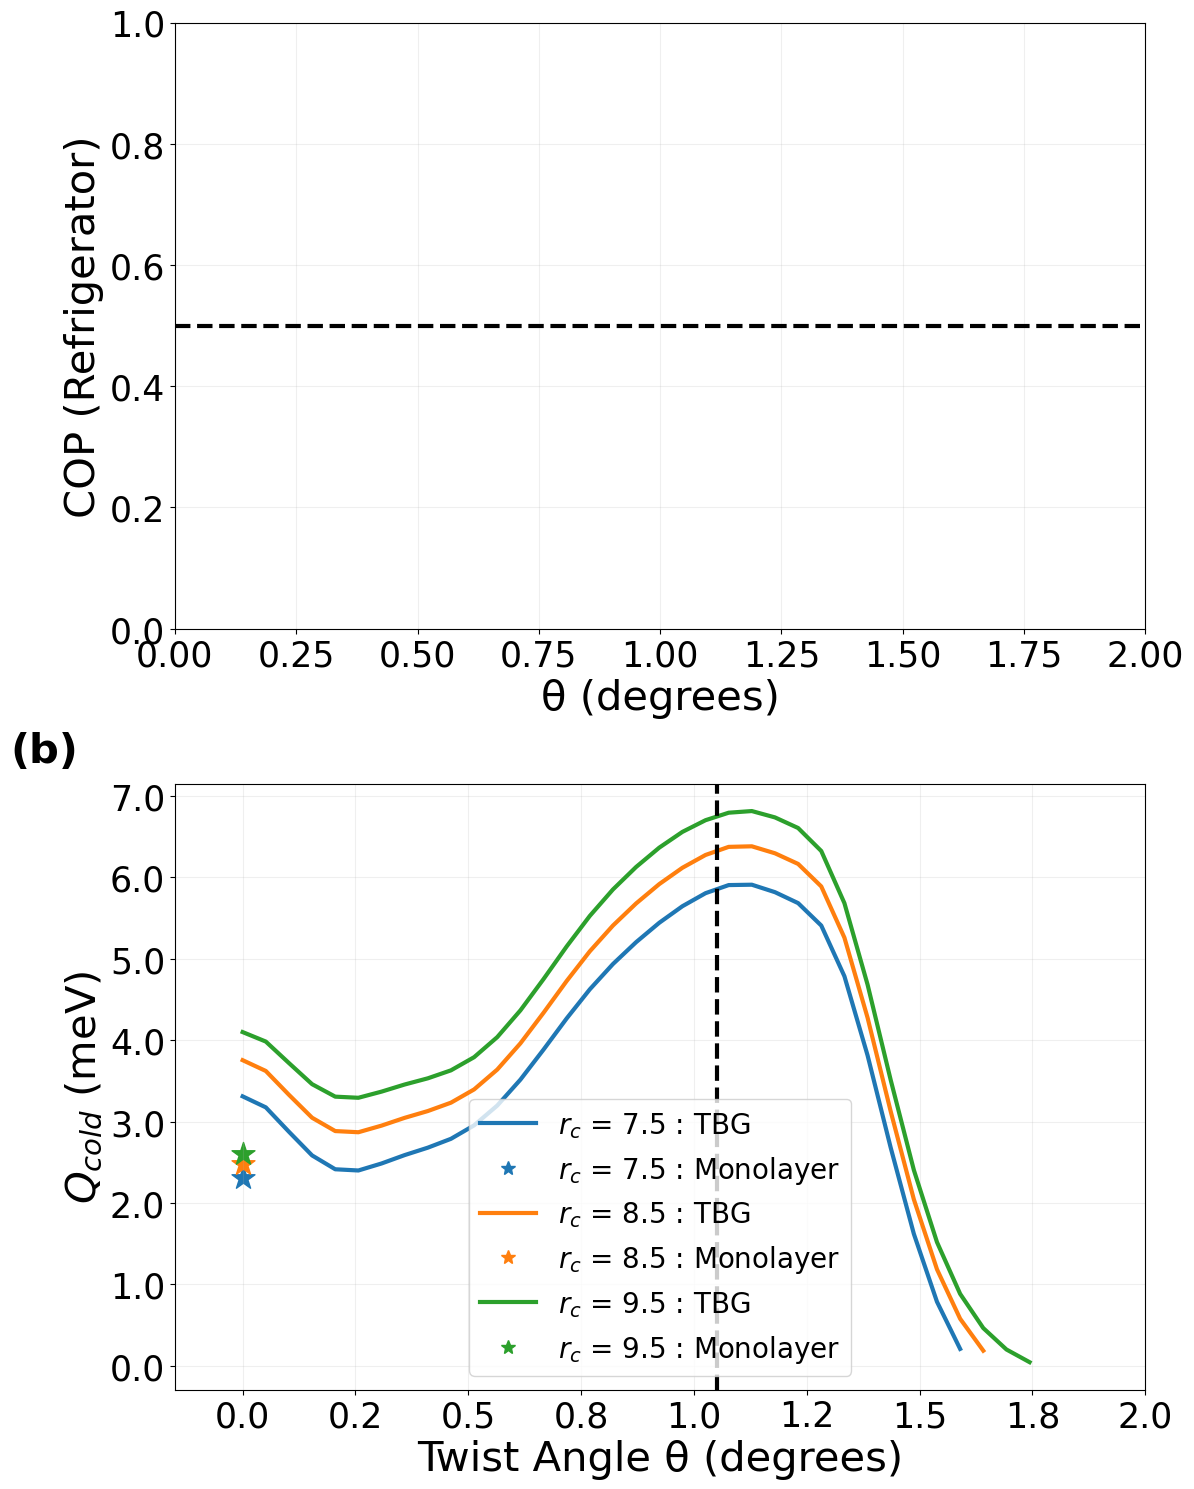

In [21]:
T_cold = 50  # Cold reservoir temperature (K)
T_hot = 150  # Hot reservoir temperature (K)
B1 = 1  # Magnetic field in Tesla


carnot_cop = T_cold/(T_hot - T_cold)


Theta_deg = ["Bilayer"] + np.linspace(0.0001, 2, 40).tolist()
Theta = [np.radians(t) if isinstance(t, (int, float)) else t for t in Theta_deg]


rc_values = [7.5, 8.5, 9.5]


cop_dict = {rc: [] for rc in rc_values}
work_dict = {rc: [] for rc in rc_values}


bilayer_cop = {rc: None for rc in rc_values}
bilayer_work = {rc: None for rc in rc_values}


valid_theta_deg = []

for theta in Theta:
    
    if isinstance(theta, (int, float)):
        data = np.load(f"spectrum_theta_sweep_N{N}_rc{B1}_Ncon{N_con}_steps80.npz")
        idx = np.argmin(np.abs(data["theta_vals_deg"] - np.round(np.degrees(theta), 2)))
        Energy_B1 = data["spectra"][idx]
    elif theta == "Bilayer":
        Energy_B1 = bi_hk(N_con, B1, True)
    

    temp_cop = {rc: None for rc in rc_values}
    temp_work = {rc: None for rc in rc_values}
    
    for rc in rc_values:
        
        Heat_in, Heat_out, work, eff, COP_R_CP, COP_JP = QCC(B1, Energy_B1, rc, theta, T_cold, T_hot,Type="Twist",saved=True)
        

        if work < 0 and Heat_in < 0 and Heat_out > 0:
            temp_cop[rc] = COP_R_CP
            temp_work[rc] = Heat_out*1000
    

    if any(v is not None for v in temp_cop.values()) or not isinstance(theta, (int, float)):
        if isinstance(theta, (int, float)):
            valid_theta_deg.append(np.degrees(theta))
        
        for rc in rc_values:
            if theta == "Bilayer":
                bilayer_cop[rc] = temp_cop[rc]
                bilayer_work[rc] = temp_work[rc]
            else:
                cop_dict[rc].append(temp_cop[rc])
                work_dict[rc].append(temp_work[rc])


plt.rcParams.update({
    'axes.labelsize': 30,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 15,
    'lines.linewidth': 3
})


fig, axs = plt.subplots(2, 1, figsize=(12, 15))
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.grid(True, alpha=0.2)

# LEFT PLOT — COP vs θ
ax = axs[0]
ax.axhline(y=carnot_cop, color='black', linestyle='--', linewidth=3, label='Carnot COP')


ax.set_xlabel('θ (degrees)', fontsize=30)
ax.set_ylabel('COP (Refrigerator)', fontsize=30)
ax.set_xlim(0, 2)


# RIGHT PLOT — Work Input vs θ
ax = axs[1]
legend_handles = []
legend_labels = []

for rc in rc_values:
    valid_work = [val for val in work_dict[rc] if val is not None]
    valid_theta = [theta for theta, val in zip(valid_theta_deg, work_dict[rc]) if val is not None]

    if valid_work:
        line, = ax.plot(valid_theta, valid_work, linewidth=3)
        color = line.get_color()
        legend_handles.append(Line2D([], [], color=color, linewidth=3))
        legend_labels.append(f'$r_c$ = {rc} : TBG')

        if bilayer_work[rc] is not None:
            ax.scatter(0, bilayer_work[rc], marker='*', s=300, color=color)
            legend_handles.append(Line2D([], [], color=color, marker='*', linestyle='None', markersize=10))
            legend_labels.append(f'$r_c$ = {rc} : Monolayer')

ax.set_xlabel('Twist Angle θ (degrees)', fontsize=30)
ax.set_ylabel(r'$Q_{cold}$ (meV)', fontsize=30)
ax.set_xlim(-0.15, 2)
ax.legend(legend_handles, legend_labels, fontsize=20, loc='best')
ax.axvline(x=1.05, color='black', linestyle='--', label='Magic Angle (~1.05°)',linewidth=3)
ax.annotate(f'(b)', xy=(-0.10, 1.02), xycoords='axes fraction',fontsize=30, weight='bold', ha='right', va='bottom')
plt.tight_layout()
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
plt.show()
